In [1]:
# example of a cnn for image classification
from numpy import unique
from numpy import argmax
import tensorflow as tf
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import (Conv2D, DepthwiseConv2D, SeparableConv2D)
from tensorflow.keras.layers import (MaxPool2D, AveragePooling2D)
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tqdm.notebook import tqdm

In [4]:
# load dataset
(x_train, y_train), (x_test, y_test) = load_data()
# determine the shape of the input images
in_shape = x_train.shape[1:]
# determine the number of classes
n_classes = len(unique(y_train))
print(in_shape, n_classes)
# normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

(32, 32, 3) 10


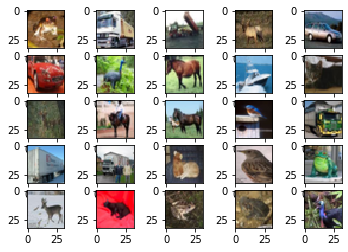

In [5]:
# visualize some images
from matplotlib import pyplot
for i in range(25):
    # define subplot
    pyplot.subplot(5, 5, i+1)
    # plot raw pixel data
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [6]:
def create_conv(out_chan, kernel, **params):
    block = []
    activation = params['activation']
    if params.get('depthwise_conv'):
        if params.get('separable_conv'):
            block += [
                DepthwiseConv2D(kernel_size=(kernel, 1)),
                DepthwiseConv2D(kernel_size=(1, kernel)),
            ]
        else:
            block += [
                DepthwiseConv2D(kernel_size=kernel),
            ]
        block += [
            Conv2D(filters=out_chan, kernel_size=1, activation=activation)
        ]
    else:
        if params.get('separable_conv'):
            block += [ # TODO: How to do this correctly?
                DepthwiseConv2D(kernel_size=(kernel, 1)),
                Conv2D(out_chan, kernel_size=(1, kernel), activation=activation),
            ]
        else:
            block += [
                Conv2D(out_chan, kernel_size=kernel, activation=activation),
            ]
    return block
    

def create_model(in_shape, out_shape, **params):
    model = Sequential([
        InputLayer(input_shape=in_shape),
        *create_conv(out_chan=6, kernel=5, **params),
        AveragePooling2D(pool_size=(2,2)),
        *create_conv(out_chan=16, kernel=5, **params),
        AveragePooling2D(pool_size=(2,2)),
        *create_conv(out_chan=120, kernel=5, **params),
        Flatten(),
        # NOTE: sometimes we can use different activations
        Dense(84, activation=params['activation']),
        Dense(out_shape, activation='softmax')
    ])

    return model

In [6]:
# define model
params_list = []
for depth in [True, False]:
    for sep in [True, False]:
        for act in ['tanh', 'relu', 'elu']:
            params_list.append({'activation':act, 'depthwise_conv': depth, 'separable_conv': sep})


models = dict()
for params in params_list:
    name = params['activation'] + ('_depthwise' if params['depthwise_conv'] else '') + ('_spatial' if params['separable_conv'] else '') 
    model = create_model(in_shape, n_classes, **params)
    models[name] = model

In [7]:
# printing model summaries
for name, model in models.items():
    print('-'*80)
    print('NAME ' + name)
    model.summary()

--------------------------------------------------------------------------------
NAME tanh_depthwise_spatial
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv2d (DepthwiseC (None, 28, 32, 3)         18        
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 28, 28, 3)         18        
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         24        
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
depthwise_conv2d_2 (Depthwis (None, 10, 14, 6)         36        
_________________________________________________________________
depthwise_conv2d_3 (Depthwis (None, 10, 10, 6)         36        
_____________

In [12]:
# Converting the models to tflite format and saving them
!mkdir -p tflite_models

for name, model in tqdm(models.items()):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # write it to file
    filepath = f'tflite_models/{name}.tflite'
    with open(filepath, 'wb') as f:
        f.write(tflite_model)

**Benchmark tool:** https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/tools/benchmark

In [12]:
# run benchmarks and write results

import os
import subprocess

def run_benchmarks(tf_path, filepaths, output_dir):
    '''
    Benchmark tflite models and write the results in a directory.
    '''
    # path to benchmark tool binary
    benchmarktool=os.path.join(tf_path, "bazel-bin/tensorflow/lite/tools/benchmark/benchmark_model")

    # convert to absolute output path
    output_dir = os.path.abspath(output_dir)

    for filepath in tqdm(filepaths):
        # create a name for csv output file
        model_filename = os.path.basename(filepath)
        
        # get the part without extension
        model_name = model_filename.rsplit('.', maxsplit=1)[0]
        output_file = os.path.join(output_dir, model_name + '_benchmark.txt')
        
        # create the shell arguments for execution
        argv = [benchmarktool,
                f"--graph={filepath}",
                "--enable_op_profiling=true",
                f"--profiling_output_csv_file={output_file}"]

        
        # execute the shell command
        print("Running:", ' \\\n'.join(argv))
        process = subprocess.Popen(argv,
                             stdout=subprocess.PIPE, 
                             stderr=subprocess.PIPE)
        # get the outputs and print them
        stdout, stderr = process.communicate()
        print(stdout.decode())
        print(stderr.decode())


def abs_listdir(path):
    '''Lists absolute paths of files in a directory.'''

    # convert to absolute path
    path = os.path.abspath(path)
    return [os.path.join(path, f) for f in os.listdir(path)]

# create results output directory
!mkdir -p results

# get the filepaths of tflite models from directory
filepaths = abs_listdir('tflite_models/')
run_benchmarks(tf_path="/home/sobir/Downloads/tf", filepaths=filepaths, output_dir='results')

Running: /home/sobir/Downloads/tf/bazel-bin/tensorflow/lite/tools/benchmark/benchmark_model \
--graph=/home/sobir/Desktop/dsproject/tflite_models/relu_depthwise_spatial.tflite \
--enable_op_profiling=true \
--profiling_output_csv_file=/home/sobir/Desktop/dsproject/results/relu_depthwise_spatial_benchmark.txt
STARTING!
Min num runs: [50]
Min runs duration (seconds): [1]
Max runs duration (seconds): [150]
Inter-run delay (seconds): [-1]
Num threads: [1]
Benchmark name: []
Output prefix: []
Min warmup runs: [1]
Min warmup runs duration (seconds): [0.5]
Graph: [/home/sobir/Desktop/dsproject/tflite_models/relu_depthwise_spatial.tflite]
Input layers: []
Input shapes: []
Input value ranges: []
Input layer values files: []
Allow fp16 : [0]
Require full delegation : [0]
Enable op profiling: [1]
Max profiling buffer entries: [1024]
CSV File to export profiling data to: [/home/sobir/Desktop/dsproject/results/relu_depthwise_spatial_benchmark.txt]
Max number of delegated partitions : [0]
Enable pla

STARTING!
Min num runs: [50]
Min runs duration (seconds): [1]
Max runs duration (seconds): [150]
Inter-run delay (seconds): [-1]
Num threads: [1]
Benchmark name: []
Output prefix: []
Min warmup runs: [1]
Min warmup runs duration (seconds): [0.5]
Graph: [/home/sobir/Desktop/dsproject/tflite_models/relu_spatial.tflite]
Input layers: []
Input shapes: []
Input value ranges: []
Input layer values files: []
Allow fp16 : [0]
Require full delegation : [0]
Enable op profiling: [1]
Max profiling buffer entries: [1024]
CSV File to export profiling data to: [/home/sobir/Desktop/dsproject/results/relu_spatial_benchmark.txt]
Max number of delegated partitions : [0]
Enable platform-wide tracing: [0]
Use gpu : [0]
Use xnnpack : [0]
Loaded model /home/sobir/Desktop/dsproject/tflite_models/relu_spatial.tflite
The input model file size (MB): 0.089844
Initialized session in 0.263ms.
Running benchmark for at least 1 iterations and at least 0.5 seconds but terminate if exceeding 150 seconds.
count=3758 firs

STARTING!
Min num runs: [50]
Min runs duration (seconds): [1]
Max runs duration (seconds): [150]
Inter-run delay (seconds): [-1]
Num threads: [1]
Benchmark name: []
Output prefix: []
Min warmup runs: [1]
Min warmup runs duration (seconds): [0.5]
Graph: [/home/sobir/Desktop/dsproject/tflite_models/elu_depthwise_spatial.tflite]
Input layers: []
Input shapes: []
Input value ranges: []
Input layer values files: []
Allow fp16 : [0]
Require full delegation : [0]
Enable op profiling: [1]
Max profiling buffer entries: [1024]
CSV File to export profiling data to: [/home/sobir/Desktop/dsproject/results/elu_depthwise_spatial_benchmark.txt]
Max number of delegated partitions : [0]
Enable platform-wide tracing: [0]
Use gpu : [0]
Use xnnpack : [0]
Loaded model /home/sobir/Desktop/dsproject/tflite_models/elu_depthwise_spatial.tflite
The input model file size (MB): 0.059576
Initialized session in 0.359ms.
Running benchmark for at least 1 iterations and at least 0.5 seconds but terminate if exceeding 1

In [97]:
# parse benchmark result files (pseudo-csv files:)) and save as csv
def parse(file):
    '''Parses benchmark result file.'''
    lines = file.readlines()
    # get the line number of the following line:
    # Operator-wise Profiling Info for Regular Benchmark Runs:
    line_number = lines.index('Operator-wise Profiling Info for Regular Benchmark Runs:\n')
    # skip the next line as it is this:
    # ============================== Run Order ==============================
    line_number += 1
    # get the nearest next line which is empty
    next_empty_line_number = lines.index('\n', line_number)

    # return all lines between
    return lines[line_number+1:next_empty_line_number]

def parse_benchmark_results(input_filepaths, output_dir):
    '''
    Reads benchmark result files and parses them. Writes the new files 
    in csv format in the output directory. Returns the list of output files.
    '''
    output_files = []
    # iterate over input files
    for filepath in input_files:
        print('Parsing:', filepath)
        
        # open the file and parse it
        with open(filepath) as f:
            lines = parse(f)
        
        # extract just the filename(without extension)
        filename = os.path.basename(filepath).rsplit('.', maxsplit=1)[0]

        # write the parsed lines to file
        output_file = os.path.join(output_dir, filename + '.csv')
        with open(output_file, 'w') as f:
            f.write('\n'.join(lines))

        # add to results list
        output_files.append(output_file)
    
    print("Outputs written to:", os.path.abspath(output_dir))
    return output_files

In [98]:
# test the parse function
test_str='''

Number of nodes executed: 1
============================== Summary by node type ==============================
node type, count, avg_ms, avg %, cdf %, mem KB, times called
AllocateTensors, 1, 0.029, 100%, 100%, 0, 1

Timings (microseconds): count=1 curr=29
Memory (bytes): count=0
1 nodes observed


Operator-wise Profiling Info for Regular Benchmark Runs:
============================== Run Order ==============================
node type, start, first, avg_ms, %, cdf%, mem KB, times called, name
CONV_2D, 0, 0.11, 0.0930388, 44.8994%, 44.8994%, 0, 1, [sequential_11/conv2d_33/Conv2D]:0
ELU, 0.0931277, 0.034, 0.0300884, 14.5203%, 59.4197%, 0, 1, [sequential_11/conv2d_33/Elu]:1
AVERAGE_POOL_2D, 0.123291, 0.026, 0.0272269, 13.1394%, 72.559%, 0, 1, [sequential_11/average_pooling2d_22/AvgPool]:2
CONV_2D, 0.150559, 0.03, 0.0309657, 14.9436%, 87.5027%, 0, 1, [sequential_11/conv2d_34/Conv2D]:3
ELU, 0.181571, 0.01, 0.0102094, 4.92694%, 92.4296%, 0, 1, [sequential_11/conv2d_34/Elu]:4
AVERAGE_POOL_2D, 0.191832, 0.003, 0.00362065, 1.74728%, 94.1769%, 0, 1, [sequential_11/average_pooling2d_23/AvgPool]:5
CONV_2D, 0.195491, 0.008, 0.00765769, 3.6955%, 97.8724%, 0, 1, [sequential_11/conv2d_35/Conv2D]:6
ELU, 0.203215, 0.001, 0.000868238, 0.419001%, 98.2914%, 0, 1, [sequential_11/conv2d_35/Elu]:7
FULLY_CONNECTED, 0.204145, 0.002, 0.00214613, 1.03569%, 99.3271%, 0, 1, [sequential_11/dense_22/MatMul]:8
ELU, 0.206331, 0.001, 0.000645791, 0.311651%, 99.6387%, 0, 1, [sequential_11/dense_22/Elu]:9
FULLY_CONNECTED, 0.207017, 0, 0.000406285, 0.196068%, 99.8348%, 0, 1, [sequential_11/dense_23/MatMul]:10
SOFTMAX, 0.207468, 0.001, 0.000342312, 0.165195%, 100%, 0, 1, [Identity]:11

============================== Top by Computation Time ==============================
node type, start, first, avg_ms, %, cdf%, mem KB, times called, name
CONV_2D, 0, 0.11, 0.0930388, 44.8994%, 44.8994%, 0, 1, [sequential_11/conv2d_33/Conv2D]:0
'''

from io import StringIO
file = StringIO(test_str)
lines = parse(file)
assert len(lines) == 13

In [99]:
input_files = [f for f in abs_listdir('results/') if f.endswith('.txt')] 
csv_results = parse_benchmark_results(input_files, output_dir='results')

Parsing: /home/sobir/Desktop/dsproject/results/elu_depthwise_spatial_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/relu_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/elu_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/elu_spatial_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/tanh_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/elu_depthwise_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/relu_spatial_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/relu_depthwise_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/tanh_depthwise_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/tanh_depthwise_spatial_benchmark.txt
Outputs written to: /home/sobir/Desktop/dsproject/results


In [102]:
# display one of the csv files
import numpy as np
import pandas as pd
pd.read_csv(csv_results[0])

,node type,start,first,avg_ms,%,cdf%,mem KB,times called,name
0,DEPTHWISE_CONV_2D,0.000000,0.044,0.040141,21.8193%,21.8193%,0,1,[sequential_2/depthwise_conv2d_12/depthwise]:0
1,DEPTHWISE_CONV_2D,0.040204,0.046,0.035149,19.1062%,40.9254%,0,1,[sequential_2/depthwise_conv2d_13/depthwise]:1
2,CONV_2D,0.075411,0.014,0.014752,8.01887%,48.9443%,0,1,[sequential_2/conv2d_6/Conv2D]:2
3,ELU,0.090220,0.024,0.024294,13.2057%,62.15%,0,1,[sequential_2/conv2d_6/Elu]:3
4,AVERAGE_POOL_2D,0.114573,0.026,0.026914,14.6297%,76.7797%,0,1,[sequential_2/average_pooling2d_4/AvgPool]:4
5,DEPTHWISE_CONV_2D,0.141532,0.012,0.011606,6.30876%,83.0885%,0,1,[sequential_2/depthwise_conv2d_14/depthwise]:5
6,DEPTHWISE_CONV_2D,0.153186,0.008,0.008561,4.65348%,87.742%,0,1,[sequential_2/depthwise_conv2d_15/depthwise]:6
7,CONV_2D,0.161796,0.003,0.002984,1.62188%,89.3639%,0,1,[sequential_2/conv2d_7/Conv2D]:7
8,ELU,0.164821,0.009,0.009356,5.08548%,94.4493%,0,1,[sequential_2/conv2d_7/Elu]:8
9,AVERAGE_POOL_2D,0.174221,0.004,0.003577,1.94423%,96.3936%,0,1,[sequential_2/average_pooling2d_5/AvgPool]:9
